# <b>Assignment 2: CNNs for image classification</b>




In [5]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2024-11-09 06:42:15--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: 'cifar-10-python.tar.gz'

cifar-10-python.tar 100%[===================>] 162.60M  77.5MB/s    in 2.1s    

2024-11-09 06:42:17 (77.5 MB/s) - 'cifar-10-python.tar.gz' saved [170498071/170498071]



In [6]:
!tar -xzvf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Helper function

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns
import time
from sklearn.metrics import confusion_matrix

def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, title):
    epochs = range(1, len(train_losses) + 1)

    # Plot accuracy curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
    plt.title(f'Training vs. Validation Accuracy ({title})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title(f'Training vs. Validation Loss ({title})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def calculate_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def generate_confusion_matrix(model, dataloader, device, label_names, title):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix ({title})')
    plt.show()
    
def measure_gflops(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    total_flops = 0
    total_time = 0

    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            start_time = time.time()
            model(inputs)
            end_time = time.time()
            total_time += (end_time - start_time)


            # Extremely rough estimation of FLOPs.  Replace with a more accurate method if needed.
            # This assumes a single forward pass
            total_flops += sum(p.numel() for p in model.parameters())

    gflops = (total_flops * 2) / (total_time * 1e9)
    return gflops

def train_and_validate(
    model,
    train_dataloader,
    test_dataloader,
    criterion,
    optimizer,
    num_epochs,
    device='cpu'
):
    # Initialize lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Loop over epochs
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_dataloader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in test_dataloader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(test_dataloader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print metrics for the current epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    print('Finished Training')

    return train_losses, val_losses, train_accuracies, val_accuracies

def initialize_training_components(
    model_fn,
    learning_rate=0.001,
    weight_decay=0.000,
    num_epochs=15,
    patience=2
):
    # Define the device (CPU or GPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Instantiate the model and move it to the device
    model = model_fn().to(device)

    # Define the loss function
    criterion = nn.CrossEntropyLoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Initialize early stopping parameters
    early_stopping = {
        'patience': patience,
        'best_val_loss': float('inf'),
        'epochs_without_improvement': 0
    }

    return {
        'device': device,
        'model': model,
        'criterion': criterion,
        'optimizer': optimizer,
        'num_epochs': num_epochs,
        'early_stopping': early_stopping
    }

In [7]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [8]:
data_batch_1 = unpickle('cifar-10-batches-py/data_batch_1')
data_batch_2 = unpickle('cifar-10-batches-py/data_batch_2')
data_batch_3 = unpickle('cifar-10-batches-py/data_batch_3')
data_batch_4 = unpickle('cifar-10-batches-py/data_batch_4')
data_batch_5 = unpickle('cifar-10-batches-py/data_batch_5')
test_batch = unpickle('cifar-10-batches-py/test_batch')

In [9]:
test_batch.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [10]:
data_batch_1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [11]:
len(data_batch_1[b'filenames']), len(data_batch_2[b'filenames']), len(data_batch_3[b'filenames']), len(data_batch_4[b'filenames']), len(data_batch_5[b'filenames']), len(test_batch[b'filenames'])

(10000, 10000, 10000, 10000, 10000, 10000)

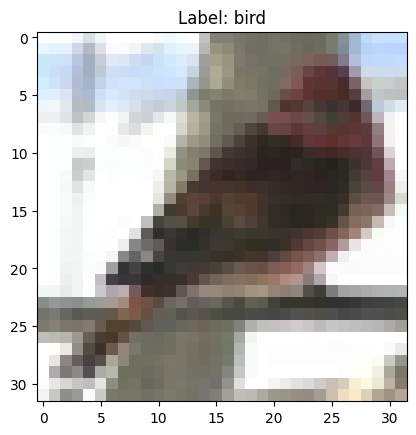

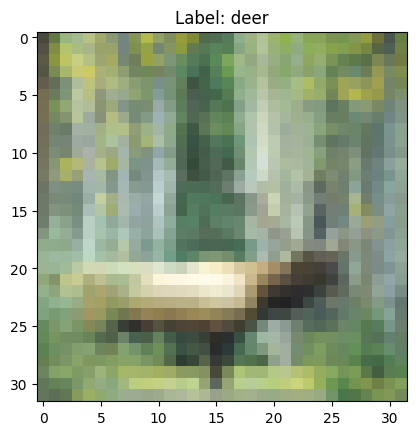

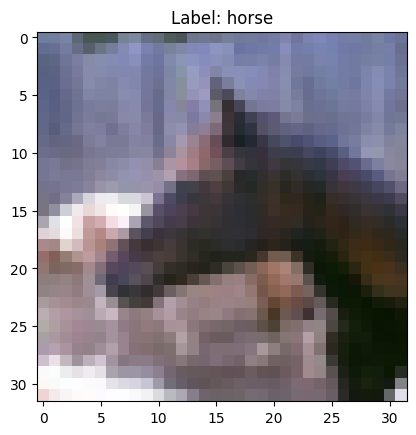

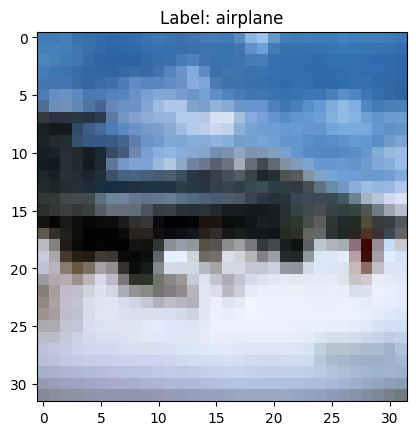

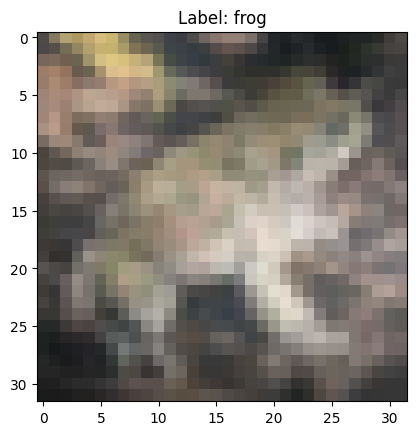

In [12]:
import matplotlib.pyplot as plt
import numpy as np

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Select a few random images from the dataset
num_images_to_show = 5
random_indices = np.random.choice(len(data_batch_1[b'data']), num_images_to_show)

for index in random_indices:
  image = data_batch_1[b'data'][index].reshape(3, 32, 32).transpose(1, 2, 0)
  label = data_batch_1[b'labels'][index]

  plt.imshow(image)
  plt.title(f'Label: {label_names[label]}')
  plt.show()

In [13]:
combined_data = {
    b'batch_label': b'combined_batches',
    b'data': np.concatenate((data_batch_1[b'data'], data_batch_2[b'data'], data_batch_3[b'data'], data_batch_4[b'data'], data_batch_5[b'data'])),
    b'labels': data_batch_1[b'labels'] + data_batch_2[b'labels'] + data_batch_3[b'labels'] + data_batch_4[b'labels'] + data_batch_5[b'labels'],
    b'filenames': data_batch_1[b'filenames'] + data_batch_2[b'filenames'] + data_batch_3[b'filenames'] + data_batch_4[b'filenames'] + data_batch_5[b'filenames']
}

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].reshape(3, 32, 32).transpose(1, 2, 0)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define the transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [15]:
from sklearn.model_selection import train_test_split

# Split the combined data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    combined_data[b'data'], combined_data[b'labels'], test_size=0.2, random_state=42
)

# Create the training dataset
train_dataset = CIFAR10Dataset(train_data, train_labels, transform=transform)

# Create the training DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# Create the testing dataset
test_dataset = CIFAR10Dataset(test_data, test_labels, transform=transform)

# Create the testing DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

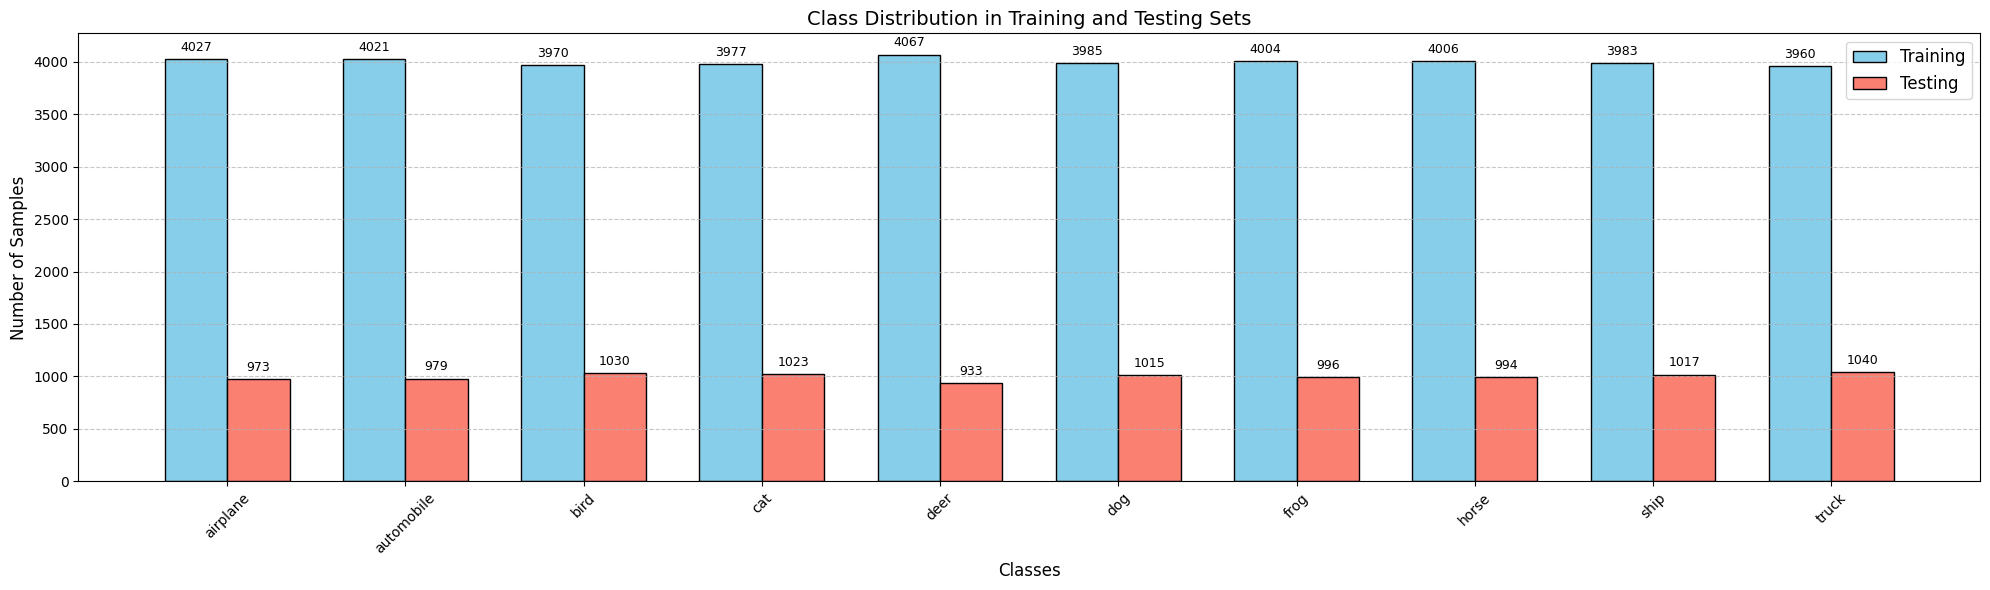

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Calculate class distributions
train_class_counts = Counter(train_labels)
test_class_counts = Counter(test_labels)

# Order counts according to label_names
train_counts = [train_class_counts[i] for i in range(len(label_names))]
test_counts = [test_class_counts[i] for i in range(len(label_names))]

# Creating a grouped bar chart
x = np.arange(len(label_names))  # Label positions
width = 0.35  # Bar width

plt.figure(figsize=(20, 6))

# Bars for training and testing sets
bars1 = plt.bar(x - width / 2, train_counts, width, label='Training', color='skyblue', edgecolor='black')
bars2 = plt.bar(x + width / 2, test_counts, width, label='Testing', color='salmon', edgecolor='black')

# Adding title and labels
plt.title('Class Distribution in Training and Testing Sets', fontsize=14)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(x, label_names, rotation=45)

# Adding counts on top of bars
for bar in bars1 + bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 50, f'{int(height)}', ha='center', va='bottom', fontsize=9)

# Adjusting legend to avoid blocking the chart
plt.legend(fontsize=12)

# Aesthetic improvements
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## <b>1. ResNet18</b>


In [ ]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += residual
        out = self.relu(out)

        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.0):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self.make_layer(64, 4, stride=1)  # 4 blocks of 64 filters
        self.layer2 = self.make_layer(128, 4, stride=2)  # 4 blocks of 128 filters
        self.layer3 = self.make_layer(256, 4, stride=2)  # 4 blocks of 256 filters
        self.layer4 = self.make_layer(512, 4, stride=2)  # 4 blocks of 512 filters

        self.dropout = nn.Dropout(dropout_rate)

        # Average pooling and final fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def make_layer(self, out_channels, blocks, stride=1):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Apply dropout
        x = self.fc(x)

        return x

def create_resnet18(num_classes=10, dropout_rate=0.0):
    model = ResNet18(num_classes=num_classes, dropout_rate=dropout_rate)
    return model


In [15]:
config_resnet18 = initialize_training_components(
    model_fn=lambda: create_resnet18(num_classes=10),
    learning_rate=0.001,
    weight_decay=0.005,
    num_epochs=20,
    patience=3
)

device = config_resnet18['device']
resnet18 = config_resnet18['model']
criterion = config_resnet18['criterion']
optimizer = config_resnet18['optimizer']
num_epochs = config_resnet18['num_epochs']
early_stopping = config_resnet18['early_stopping']

In [16]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    model=resnet18,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

Epoch [1/20], Train Loss: 1.5452, Train Acc: 44.03%, Val Loss: 1.6124, Val Acc: 41.26%

Epoch [2/20], Train Loss: 1.1472, Train Acc: 58.83%, Val Loss: 1.2291, Val Acc: 55.95%

Epoch [3/20], Train Loss: 0.9855, Train Acc: 64.75%, Val Loss: 1.1787, Val Acc: 57.56%

Epoch [4/20], Train Loss: 0.8774, Train Acc: 68.96%, Val Loss: 1.4264, Val Acc: 51.99%

Epoch [5/20], Train Loss: 0.8335, Train Acc: 70.63%, Val Loss: 1.1785, Val Acc: 60.05%

Epoch [6/20], Train Loss: 0.7307, Train Acc: 74.31%, Val Loss: 1.2259, Val Acc: 60.34%

Epoch [7/20], Train Loss: 0.6548, Train Acc: 77.02%, Val Loss: 1.1270, Val Acc: 62.45%

Epoch [8/20], Train Loss: 0.5975, Train Acc: 78.98%, Val Loss: 1.1965, Val Acc: 61.92%

Epoch [9/20], Train Loss: 0.5759, Train Acc: 80.02%, Val Loss: 1.3373, Val Acc: 59.38%

Epoch [10/20], Train Loss: 0.5635, Train Acc: 80.34%, Val Loss: 1.1856, Val Acc: 61.40%

Epoch [11/20], Train Loss: 0.4816, Train Acc: 83.09%, Val Loss: 1.2056, Val Acc: 61.91%

Epoch [12/20], Train Loss: 0.4

In [ ]:
# Evaluate the model on the training and testing sets
train_accuracy_resnet18 = calculate_accuracy(resnet18, train_dataloader, device)
test_accuracy_resnet18 = calculate_accuracy(resnet18, test_dataloader, device)

print(f'Training Accuracy: {train_accuracy_resnet18:.4f}')
print(f'Testing Accuracy: {test_accuracy_resnet18:.4f}')

Training Accuracy: 0.7360

Testing Accuracy: 0.6019


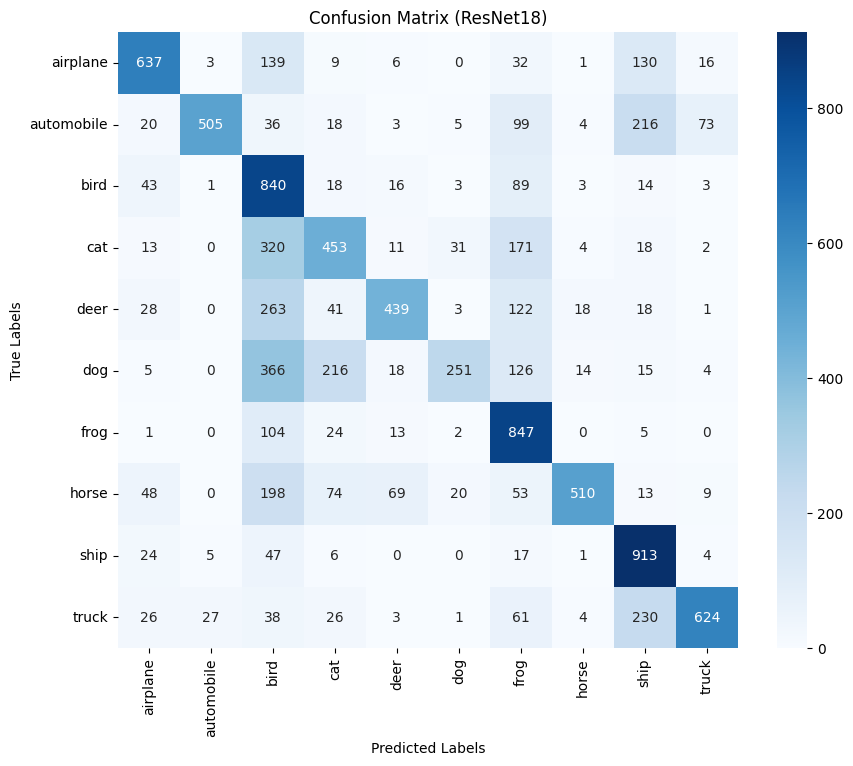

In [ ]:
generate_confusion_matrix(resnet18, test_dataloader, device, label_names, 'ResNet18')

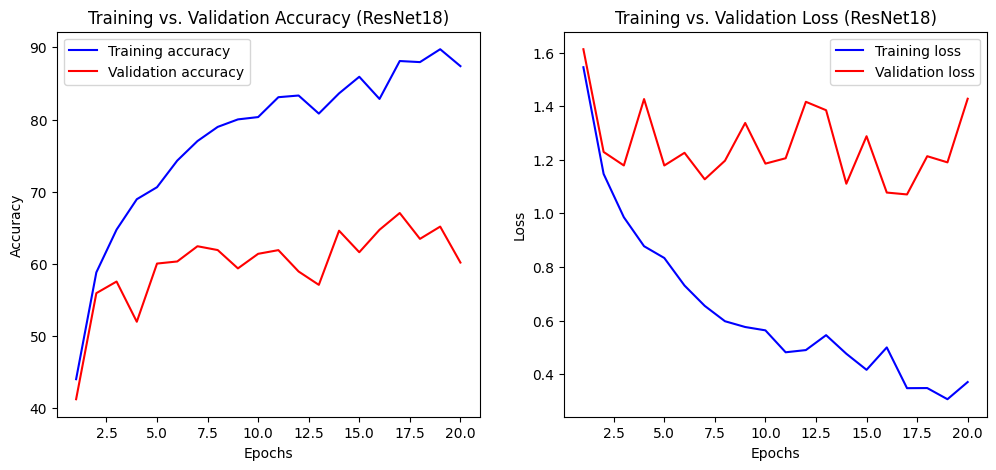

In [19]:
plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, 'ResNet18')

In [ ]:
gflops_resnet18 = measure_gflops(resnet18, test_dataloader, device)
efficiency_resnet18 = test_accuracy_resnet18/gflops_resnet18
print(f'ResNet-18 GFLOPs: {gflops_resnet18:.2f}')
print(f'ResNet-18 Efficiency: {efficiency_resnet18}')

ResNet-18 GFLOPs: 7.37

ResNet-18 Efficiency: 0.08164610172739012


## <b>1.1 ResNet18 - Hyperparameter Tuning</b>


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
import optuna
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

class TrainingPipeline:
    def __init__(self, model_class, dataset, num_classes, device='cuda'):
        self.model_class = model_class
        self.dataset = dataset
        self.num_classes = num_classes
        self.device = device
        self.best_params = None
        self.best_model = None
        self.best_accuracy = 0.0

    def objective(self, trial):
        # Hyperparameters to optimize
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
            'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128]),
            'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
            'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True),
        }

        # K-Fold Cross-validation
        k_folds = 5
        kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
        fold_accuracies = []

        for fold, (train_ids, val_ids) in enumerate(kfold.split(self.dataset)):
            # Data loaders for this fold
            train_sampler = SubsetRandomSampler(train_ids)
            val_sampler = SubsetRandomSampler(val_ids)
            
            train_loader = DataLoader(
                self.dataset, 
                batch_size=params['batch_size'],
                sampler=train_sampler,
                num_workers=4,
                pin_memory=True
            )
            
            val_loader = DataLoader(
                self.dataset,
                batch_size=params['batch_size'],
                sampler=val_sampler,
                num_workers=4,
                pin_memory=True
            )

            # Initialize model for this fold
            model = self.model_class(
                num_classes=self.num_classes,
                dropout_rate=params['dropout_rate']
            ).to(self.device)

            # Training setup
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.AdamW(
                model.parameters(),
                lr=params['learning_rate'],
                weight_decay=params['weight_decay']
            )
            scheduler = ReduceLROnPlateau(
                optimizer,
                mode='max',
                factor=0.1,
                patience=5,
                verbose=True
            )

            # Training loop for this fold
            best_fold_acc = 0.0
            patience = 10
            patience_counter = 0
            
            for epoch in range(50):  # Maximum 50 epochs per fold
                # Training phase
                model.train()
                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                # Validation phase
                model.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(self.device), labels.to(self.device)
                        outputs = model(inputs)
                        _, predicted = outputs.max(1)
                        total += labels.size(0)
                        correct += predicted.eq(labels).sum().item()

                accuracy = correct / total
                scheduler.step(accuracy)

                # Early stopping check
                if accuracy > best_fold_acc:
                    best_fold_acc = accuracy
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        break

            fold_accuracies.append(best_fold_acc)
            
            # Report intermediate value for pruning
            trial.report(best_fold_acc, fold)
            if trial.should_prune():
                raise optuna.TrialPruned()

        mean_accuracy = np.mean(fold_accuracies)
        
        # Save best model if this trial produced better results
        if mean_accuracy > self.best_accuracy:
            self.best_accuracy = mean_accuracy
            self.best_params = params
            self.best_model = copy.deepcopy(model)

        return mean_accuracy

    def optimize(self, n_trials=50):
        study = optuna.create_study(direction='maximize')
        study.optimize(self.objective, n_trials=n_trials)

        print('Best trial:')
        trial = study.best_trial
        print('  Value: ', trial.value)
        print('  Params: ')
        for key, value in trial.params.items():
            print(f'    {key}: {value}')

        return self.best_model, self.best_params, self.best_accuracy

def train_with_optimal_params(dataset, num_classes):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pipeline = TrainingPipeline(ResNet18, dataset, num_classes, device)
    best_model, best_params, best_accuracy = pipeline.optimize(n_trials=5)
    return best_model, best_params, best_accuracy

In [ ]:
best_model, best_params, best_accuracy = train_with_optimal_params(
    dataset=train_dataset,
    num_classes=10
)

print(f'Best accuracy achieved: {best_accuracy}')
print('Best parameters:', best_params)

[I 2024-11-06 05:31:04,408] A new study created in memory with name: no-name-d38e1d12-a93d-4b7f-88c6-521658af3955

[I 2024-11-06 06:16:06,957] Trial 0 finished with value: 0.7604249999999999 and parameters: {'learning_rate': 0.0009576511648449288, 'batch_size': 64, 'dropout_rate': 0.1377463392580642, 'weight_decay': 0.0005012226731112186}. Best is trial 0 with value: 0.7604249999999999.

[I 2024-11-06 06:51:09,346] Trial 1 finished with value: 0.6615249999999999 and parameters: {'learning_rate': 0.00020772421656274165, 'batch_size': 128, 'dropout_rate': 0.3564891169451916, 'weight_decay': 0.00020543291756247386}. Best is trial 0 with value: 0.7604249999999999.

[I 2024-11-06 07:26:50,897] Trial 2 finished with value: 0.7212999999999999 and parameters: {'learning_rate': 0.00047980893078733265, 'batch_size': 128, 'dropout_rate': 0.42793260865366867, 'weight_decay': 5.407095262429e-05}. Best is trial 0 with value: 0.7604249999999999.

[I 2024-11-06 08:13:26,944] Trial 3 finished with valu

Best trial:

  Value:  0.760525

  Params: 

    learning_rate: 0.0010084855137595134

    batch_size: 64

    dropout_rate: 0.4893098948736213

    weight_decay: 0.0008223244238931826

Best accuracy achieved: 0.760525

Best parameters: {'learning_rate': 0.0010084855137595134, 'batch_size': 64, 'dropout_rate': 0.4893098948736213, 'weight_decay': 0.0008223244238931826}


In [18]:
config_resnet18_hyper = initialize_training_components(
    model_fn=lambda: create_resnet18(num_classes=10, dropout_rate=0.3347280381670022),
    learning_rate=0.0016784422674842826,
    weight_decay=5.484946882969722e-05,
    num_epochs=20,
    patience=3
)

device_hyper = config_resnet18_hyper['device']
resnet18_hyper = config_resnet18_hyper['model']
criterion_hyper = config_resnet18_hyper['criterion']
optimizer_hyper = config_resnet18_hyper['optimizer']
num_epochs_hyper = config_resnet18_hyper['num_epochs']
early_stopping_hyper = config_resnet18_hyper['early_stopping']

In [19]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    model=resnet18_hyper,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    criterion=criterion_hyper,
    optimizer=optimizer_hyper,
    num_epochs=num_epochs_hyper,
    device=device_hyper
)

Epoch [1/20], Train Loss: 1.6160, Train Acc: 42.37%, Val Loss: 1.6597, Val Acc: 41.37%

Epoch [2/20], Train Loss: 1.2045, Train Acc: 56.90%, Val Loss: 1.2675, Val Acc: 55.27%

Epoch [3/20], Train Loss: 0.9917, Train Acc: 64.91%, Val Loss: 1.2591, Val Acc: 57.94%

Epoch [4/20], Train Loss: 0.8790, Train Acc: 68.97%, Val Loss: 0.9829, Val Acc: 65.47%

Epoch [5/20], Train Loss: 0.7369, Train Acc: 74.12%, Val Loss: 1.1260, Val Acc: 63.42%

Epoch [6/20], Train Loss: 0.6679, Train Acc: 76.97%, Val Loss: 1.2038, Val Acc: 62.04%

Epoch [7/20], Train Loss: 0.6108, Train Acc: 78.68%, Val Loss: 0.9658, Val Acc: 68.37%

Epoch [8/20], Train Loss: 0.5008, Train Acc: 82.51%, Val Loss: 1.0615, Val Acc: 66.78%

Epoch [9/20], Train Loss: 0.4456, Train Acc: 84.46%, Val Loss: 1.3472, Val Acc: 62.25%

Epoch [10/20], Train Loss: 0.4638, Train Acc: 83.88%, Val Loss: 1.0983, Val Acc: 67.62%

Epoch [11/20], Train Loss: 0.3795, Train Acc: 86.64%, Val Loss: 1.0456, Val Acc: 70.21%

Epoch [12/20], Train Loss: 0.2

In [ ]:
# Evaluate the model on the training and testing sets
train_accuracy_resnet18_hyper = calculate_accuracy(resnet18_hyper, train_dataloader, device_hyper)
test_accuracy_resnet18_hyper = calculate_accuracy(resnet18_hyper, test_dataloader, device_hyper)

print(f'Training Accuracy: {train_accuracy_resnet18_hyper:.4f}')
print(f'Testing Accuracy: {test_accuracy_resnet18_hyper:.4f}')

Training Accuracy: 0.9798

Testing Accuracy: 0.7211


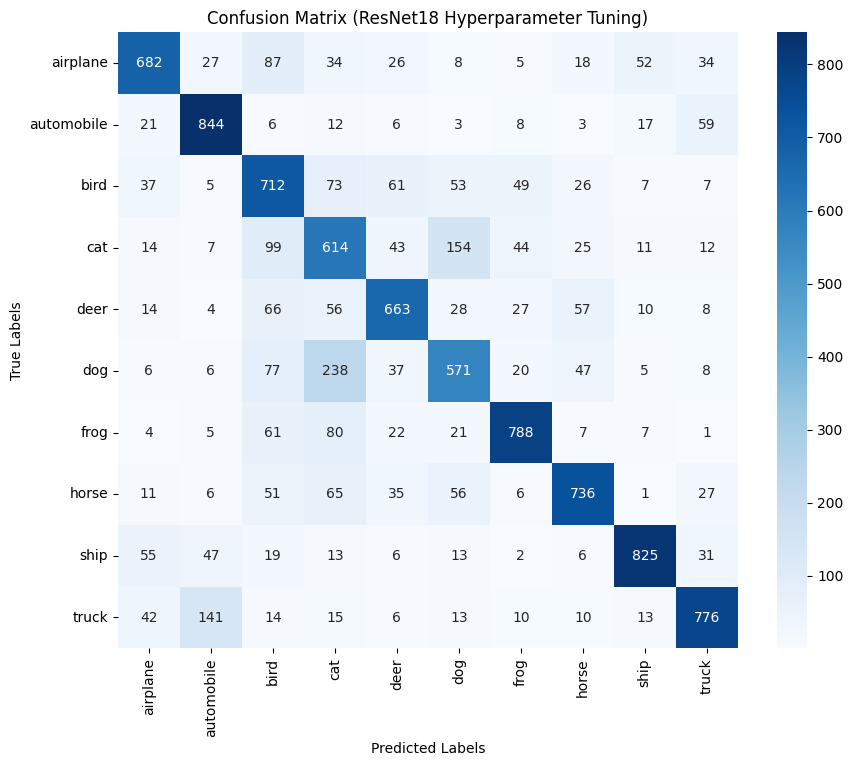

In [ ]:
generate_confusion_matrix(resnet18_hyper, test_dataloader, device_hyper, label_names, 'ResNet18 Hyperparameter Tuning')

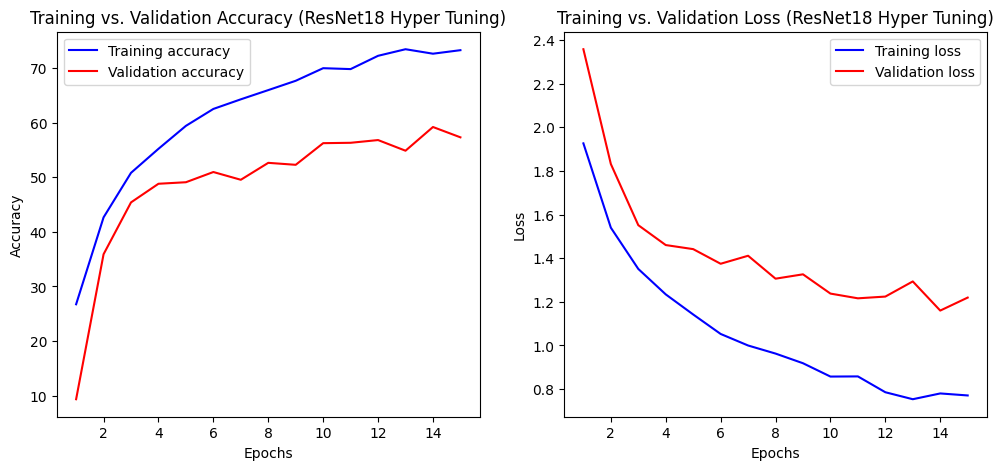

In [32]:
plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, 'ResNet18 Hyper Tuning')

In [ ]:
gflops_resnet18_hyper = measure_gflops(resnet18_hyper, test_dataloader, device_hyper)
efficiency_resnet18_hyper = test_accuracy_resnet18_hyper/gflops_resnet18_hyper
print(f'ResNet-18 Hyperparameter Tuning GFLOPs: {gflops_resnet18_hyper:.2f}')
print(f'ResNet-18 Hyperparameter Tuning Efficiency: {efficiency_resnet18_hyper}')

ResNet-18 Hyperparameter Tuning GFLOPs: 6.81

ResNet-18 Hyperparameter Tuning Efficiency: 0.10587434070101175


## <b>2: ShuffleNet V2</b>


In [21]:
import torch
import torch.nn as nn

def channel_shuffle(x, groups):
    batch_size, channels, height, width = x.size()
    channels_per_group = channels // groups

    # Reshape
    x = x.view(batch_size, groups, channels_per_group, height, width)

    # Transpose + Flatten
    x = x.transpose(1, 2).contiguous()
    x = x.view(batch_size, -1, height, width)

    return x

class ShuffleUnit(nn.Module):
    def __init__(self, in_channels, out_channels, groups=3, stride=1):
        super(ShuffleUnit, self).__init__()
        self.groups = groups
        self.stride = stride

        self.in_channels = in_channels
        self.out_channels = out_channels

        if stride == 2:
            out_channels = out_channels - in_channels

        bottleneck_channels = out_channels // 4

        if stride == 2:
            self.branch1 = nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=2,
                         padding=1, groups=in_channels, bias=False),
                nn.BatchNorm2d(in_channels),
            )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels if stride == 2 else in_channels // 2,
                     bottleneck_channels,
                     kernel_size=1, stride=1, padding=0, groups=groups, bias=False),
            nn.BatchNorm2d(bottleneck_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3,
                     stride=stride, padding=1, groups=bottleneck_channels, bias=False),
            nn.BatchNorm2d(bottleneck_channels),
            nn.Conv2d(bottleneck_channels,
                     out_channels if stride == 2 else out_channels // 2,
                     kernel_size=1, stride=1, padding=0, groups=groups, bias=False),
            nn.BatchNorm2d(out_channels if stride == 2 else out_channels // 2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        if self.stride == 2:
            x1 = self.branch1(x)
            x2 = self.branch2(x)
            out = channel_shuffle(torch.cat((x1, x2), dim=1), self.groups)
        else:
            x1, x2 = x.chunk(2, dim=1)
            x2 = self.branch2(x2)
            out = channel_shuffle(torch.cat((x1, x2), dim=1), self.groups)
        
        return out

class ShuffleNetV2(nn.Module):
    def __init__(self, input_size=32, groups=3, num_classes=10):
        super(ShuffleNetV2, self).__init__()
        self.stage_repeats = [4, 8, 4]
        self.stage_out_channels = [-1, 24, 120, 240, 480]

        input_channel = self.stage_out_channels[1]
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, input_channel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU(inplace=True)
        )

        self.stages = nn.ModuleList([])
        for stage_idx in range(len(self.stage_repeats)):
            stage_num = stage_idx + 2
            stage = []
            for i in range(self.stage_repeats[stage_idx]):
                if i == 0:
                    stage.append(ShuffleUnit(
                        self.stage_out_channels[stage_num-1],
                        self.stage_out_channels[stage_num],
                        groups=groups,
                        stride=2
                    ))
                else:
                    stage.append(ShuffleUnit(
                        self.stage_out_channels[stage_num],
                        self.stage_out_channels[stage_num],
                        groups=groups,
                        stride=1
                    ))
            self.stages.append(nn.Sequential(*stage))

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(self.stage_out_channels[-1], num_classes)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        for stage in self.stages:
            x = stage(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

def create_shufflenet_v2():
    return ShuffleNetV2(input_size=32, groups=3, num_classes=10).to(device)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Currently using device: {device}")

Currently using device: cuda


In [25]:
config_shufflenet = initialize_training_components(
    model_fn=lambda: create_shufflenet_v2().to(device),
    learning_rate=0.001,
    weight_decay=0.005,
    num_epochs=15,
    patience=2
)

device = config_shufflenet['device']
shufflenet = config_shufflenet['model']
criterion = config_shufflenet['criterion']
optimizer = config_shufflenet['optimizer']
num_epochs = config_shufflenet['num_epochs']
early_stopping = config_shufflenet['early_stopping']

In [26]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    model=shufflenet,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

Epoch [1/15], Train Loss: 2.0415, Train Acc: 23.46%, Val Loss: 2.4833, Val Acc: 9.33%
Epoch [2/15], Train Loss: 1.6026, Train Acc: 39.38%, Val Loss: 1.8314, Val Acc: 33.49%
Epoch [3/15], Train Loss: 1.3929, Train Acc: 48.34%, Val Loss: 1.4909, Val Acc: 45.78%
Epoch [4/15], Train Loss: 1.2603, Train Acc: 53.83%, Val Loss: 1.4222, Val Acc: 49.02%
Epoch [5/15], Train Loss: 1.1514, Train Acc: 58.30%, Val Loss: 1.3521, Val Acc: 51.75%
Epoch [6/15], Train Loss: 1.0612, Train Acc: 61.70%, Val Loss: 1.3679, Val Acc: 52.71%
Epoch [7/15], Train Loss: 0.9953, Train Acc: 64.60%, Val Loss: 1.1956, Val Acc: 57.63%
Epoch [8/15], Train Loss: 0.9355, Train Acc: 66.64%, Val Loss: 1.1992, Val Acc: 56.87%
Epoch [9/15], Train Loss: 0.8917, Train Acc: 68.31%, Val Loss: 1.1223, Val Acc: 60.37%
Epoch [10/15], Train Loss: 0.8260, Train Acc: 70.97%, Val Loss: 1.1664, Val Acc: 59.43%
Epoch [11/15], Train Loss: 0.7756, Train Acc: 72.59%, Val Loss: 1.1820, Val Acc: 59.14%
Epoch [12/15], Train Loss: 0.7264, Train A

In [27]:
# Evaluate the model on the training and testing sets
train_accuracy_shufflenet = calculate_accuracy(shufflenet, train_dataloader, device)
test_accuracy_shufflenet = calculate_accuracy(shufflenet, test_dataloader, device)

print(f'Training Accuracy: {train_accuracy_shufflenet:.4f}')
print(f'Testing Accuracy: {test_accuracy_shufflenet:.4f}')

Training Accuracy: 0.7702
Testing Accuracy: 0.6311


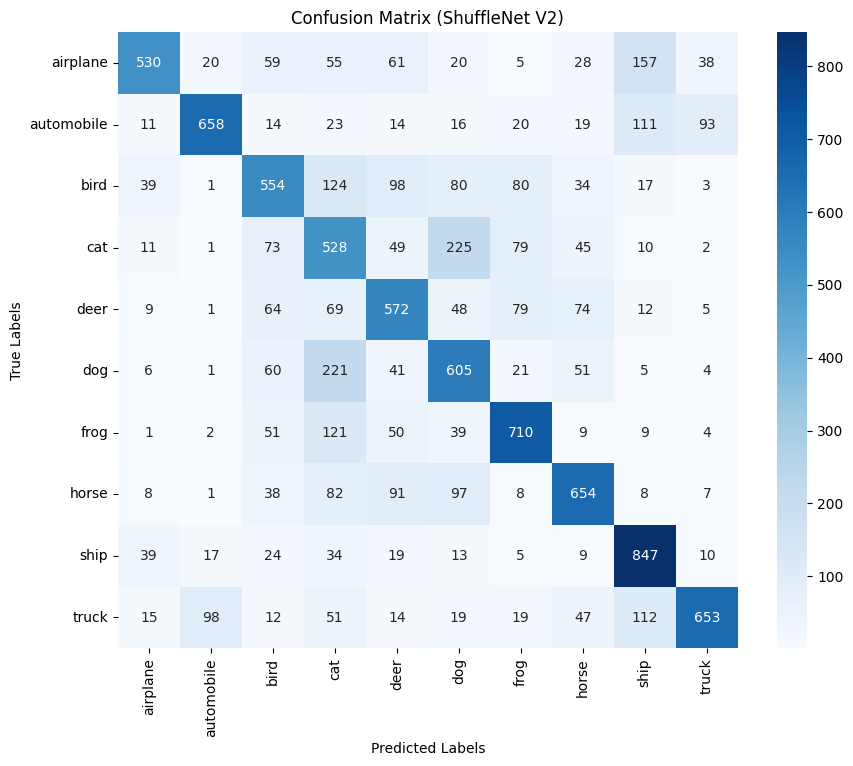

In [28]:
generate_confusion_matrix(shufflenet, test_dataloader, device, label_names, 'ShuffleNet V2')

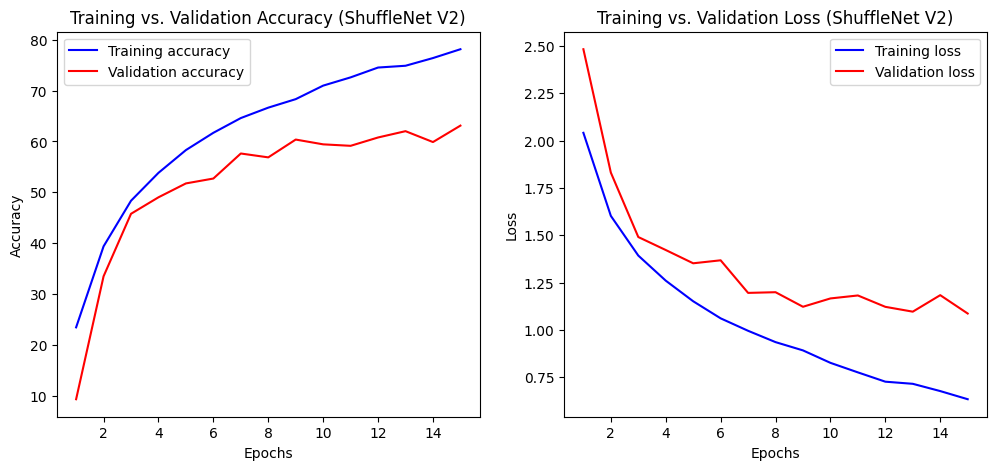

In [29]:
plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, 'ShuffleNet V2')

In [30]:
gflops_shufflenet = measure_gflops(shufflenet, test_dataloader, device)
efficiency_shufflenet = test_accuracy_shufflenet/gflops_shufflenet
print(f'ShuffleNet V2 GFLOPs: {gflops_shufflenet:.2f}')
print(f'ShuffleNet V2 Efficiency: {efficiency_shufflenet}')

ShuffleNet V2 GFLOPs: 0.03
ShuffleNet V2 Efficiency: 25.093619085260027


## <b>3: MobileNetV3</b>


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HardSigmoid(nn.Module):
    def forward(self, x):
        return F.relu6(x + 3) / 6

class HardSwish(nn.Module):
    def __init__(self, inplace: bool = False):
        super(HardSwish, self).__init__()
        self.inplace = inplace  # In this case, inplace has no effect but is accepted for compatibility

    def forward(self, x):
        return x * F.relu6(x + 3) / 6

class SEModule(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            HardSigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class MobileNetV3Block(nn.Module):
    def __init__(self, inp, oup, hidden_dim, kernel_size, stride, use_se, use_hs, reduction=4):
        super(MobileNetV3Block, self).__init__()
        self.identity = stride == 1 and inp == oup

        activation = HardSwish if use_hs else nn.ReLU

        layers = []
        # Expand
        if inp != hidden_dim:
            layers.extend([
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                activation(inplace=True)
            ])
        
        # Depthwise
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride,
                     (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            activation(inplace=True)
        ])

        # SE
        if use_se:
            layers.append(SEModule(hidden_dim, reduction))

        # Project
        layers.extend([
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup)
        ])

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV3(nn.Module):
    def __init__(self, num_classes=10, width_multiplier=1.0, mode='small'):
        super(MobileNetV3, self).__init__()
        
        # Configurations for Small architecture
        if mode == 'small':
            # kernel_size, exp_size, out_channels, use_se, use_hs, stride
            self.cfgs = [
                [3, 16,  16,  True,  False, 2],
                [3, 72,  24,  False, False, 2],
                [3, 88,  24,  False, False, 1],
                [5, 96,  40,  True,  True,  2],
                [5, 240, 40,  True,  True,  1],
                [5, 240, 40,  True,  True,  1],
                [5, 120, 48,  True,  True,  1],
                [5, 144, 48,  True,  True,  1],
                [5, 288, 96,  True,  True,  2],
                [5, 576, 96,  True,  True,  1],
                [5, 576, 96,  True,  True,  1],
            ]
            first_channels = 16
            last_channels = 576
        else:  # Large architecture
            self.cfgs = [
                [3, 16,   16,  False, False, 1],
                [3, 64,   24,  False, False, 2],
                [3, 72,   24,  False, False, 1],
                [5, 72,   40,  True,  False, 2],
                [5, 120,  40,  True,  False, 1],
                [5, 120,  40,  True,  False, 1],
                [3, 240,  80,  False, True,  2],
                [3, 200,  80,  False, True,  1],
                [3, 184,  80,  False, True,  1],
                [3, 184,  80,  False, True,  1],
                [3, 480,  112, True,  True,  1],
                [3, 672,  112, True,  True,  1],
                [5, 672,  160, True,  True,  2],
                [5, 960,  160, True,  True,  1],
                [5, 960,  160, True,  True,  1],
            ]
            first_channels = 16
            last_channels = 960

        self.features = []
        
        # First layer
        input_channels = int(first_channels * width_multiplier)
        self.features.append(nn.Sequential(
            nn.Conv2d(3, input_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(input_channels),
            HardSwish(inplace=True)
        ))

        # Building blocks
        for k, exp, out, use_se, use_hs, s in self.cfgs:
            output_channels = int(out * width_multiplier)
            exp_channels = int(exp * width_multiplier)
            self.features.append(
                MobileNetV3Block(input_channels, output_channels, exp_channels,
                               k, s, use_se, use_hs)
            )
            input_channels = output_channels

        # Last stage
        self.features.append(nn.Sequential(
            nn.Conv2d(input_channels, last_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(last_channels),
            HardSwish(inplace=True)
        ))
        
        self.features = nn.Sequential(*self.features)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(last_channels, 1280),
            HardSwish(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes)
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

def create_mobilenet(num_classes=10, width_multiplier=1.0):
    return MobileNetV3(num_classes=num_classes, width_multiplier=width_multiplier, mode='small').to('cuda')

In [32]:
config_mobilenet = initialize_training_components(
    model_fn=lambda: create_mobilenet(num_classes=10),
    learning_rate=0.001,
    weight_decay=0.005,
    num_epochs=15,
    patience=2
)

device = config_mobilenet['device']
mobilenet = config_mobilenet['model']
criterion = config_mobilenet['criterion']
optimizer = config_mobilenet['optimizer']
num_epochs = config_mobilenet['num_epochs']
early_stopping = config_mobilenet['early_stopping']

In [33]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    model=mobilenet,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

Epoch [1/15], Train Loss: 1.9129, Train Acc: 26.93%, Val Loss: 2.3531, Val Acc: 9.33%
Epoch [2/15], Train Loss: 1.4922, Train Acc: 44.10%, Val Loss: 1.8386, Val Acc: 35.42%
Epoch [3/15], Train Loss: 1.3049, Train Acc: 52.07%, Val Loss: 1.5478, Val Acc: 43.03%
Epoch [4/15], Train Loss: 1.1758, Train Acc: 57.40%, Val Loss: 1.4687, Val Acc: 47.35%
Epoch [5/15], Train Loss: 1.0841, Train Acc: 61.05%, Val Loss: 1.4010, Val Acc: 49.76%
Epoch [6/15], Train Loss: 1.0221, Train Acc: 63.39%, Val Loss: 1.3658, Val Acc: 52.34%
Epoch [7/15], Train Loss: 0.9378, Train Acc: 66.99%, Val Loss: 1.3966, Val Acc: 49.94%
Epoch [8/15], Train Loss: 0.9135, Train Acc: 67.76%, Val Loss: 1.2123, Val Acc: 57.75%
Epoch [9/15], Train Loss: 0.8562, Train Acc: 70.25%, Val Loss: 1.2083, Val Acc: 57.69%
Epoch [10/15], Train Loss: 0.8119, Train Acc: 71.47%, Val Loss: 1.2299, Val Acc: 55.96%
Epoch [11/15], Train Loss: 0.7730, Train Acc: 72.89%, Val Loss: 1.2016, Val Acc: 57.48%
Epoch [12/15], Train Loss: 0.7201, Train A

In [34]:
# Evaluate the model on the training and testing sets
train_accuracy_mobilenet = calculate_accuracy(mobilenet, train_dataloader, device)
test_accuracy_mobilenet = calculate_accuracy(mobilenet, test_dataloader, device)

print(f'Training Accuracy: {train_accuracy_mobilenet:.4f}')
print(f'Testing Accuracy: {test_accuracy_mobilenet:.4f}')

Training Accuracy: 0.7350
Testing Accuracy: 0.6059


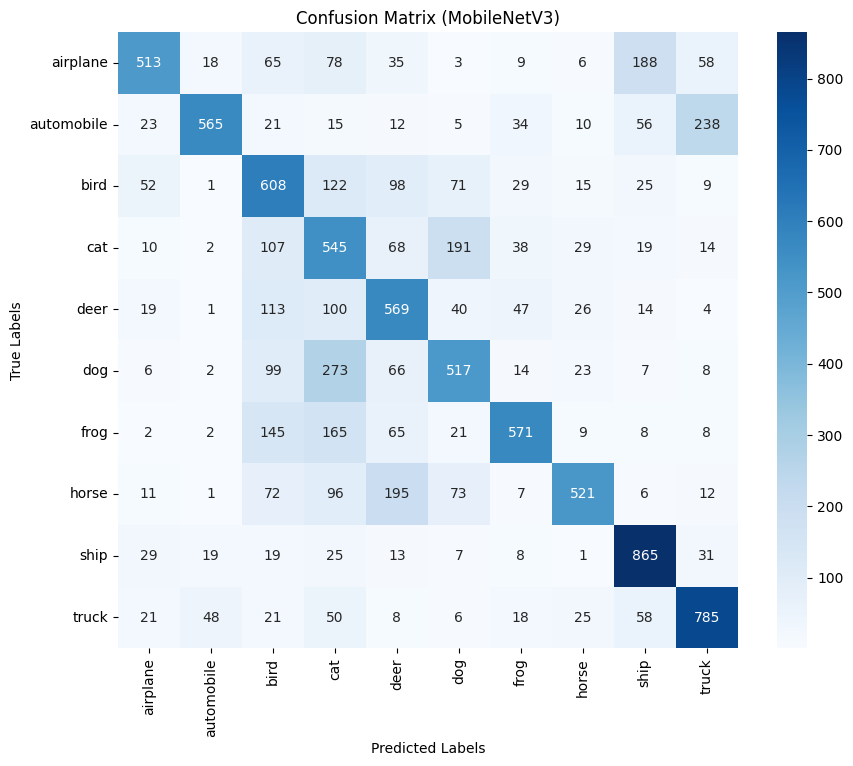

In [35]:
generate_confusion_matrix(mobilenet, test_dataloader, device, label_names, 'MobileNetV3')

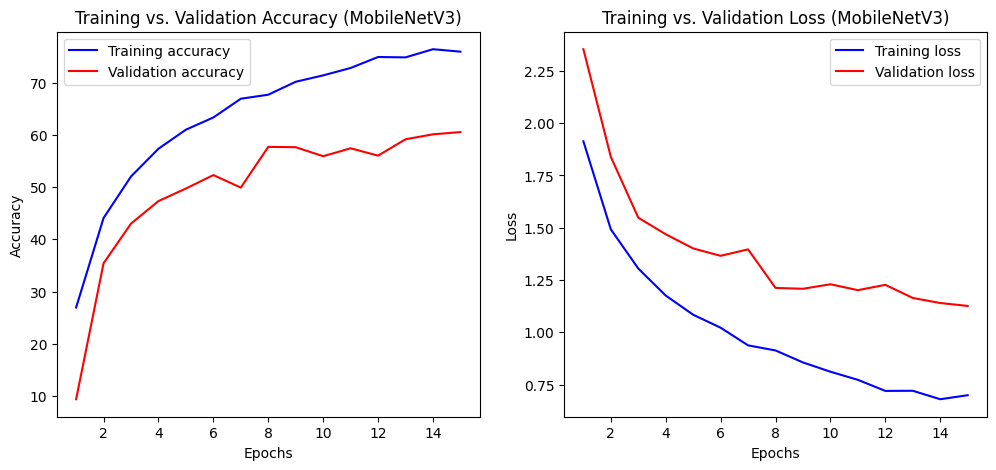

In [36]:
plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, 'MobileNetV3')

In [37]:
gflops_mobilenet = measure_gflops(mobilenet, test_dataloader, device)
efficiency_mobilenet = test_accuracy_mobilenet/gflops_mobilenet
print(f'MobileNetV3 GFLOPs: {gflops_mobilenet:.2f}')
print(f'MobileNetV3 Efficiency: {efficiency_mobilenet}')

MobileNetV3 GFLOPs: 0.39
MobileNetV3 Efficiency: 1.561337188262361
